In [8]:
import numpy as np
import glob
import pandas as pd
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.stats import sem

FONTSIZE = 18

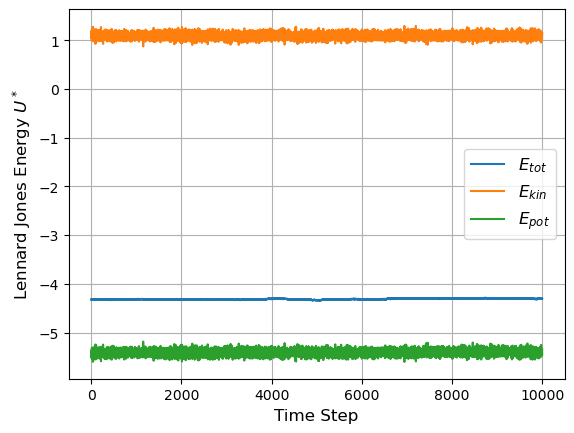

In [9]:
FONTSIZE = 12
ene = np.loadtxt('energy_output_10052004.txt')
plt.plot(ene[:,0], label=r'$E_{tot}$')
plt.plot(ene[:,1], label=r'$E_{kin}$')
plt.plot(ene[:,0]-ene[:,1], label=r'$E_{pot}$')
plt.legend(fontsize=FONTSIZE)
plt.xlabel('Time Step', fontsize=FONTSIZE)
plt.ylabel('Lennard Jones Energy $U^*$', fontsize=FONTSIZE)
plt.grid()
plt.savefig('energ_cons.png', dpi = 300)



/var/folders/87/z37n4g2j595fd7ly45xb9y680000gn/T/ipykernel_12419/486425371.py:100: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(integrand, r)


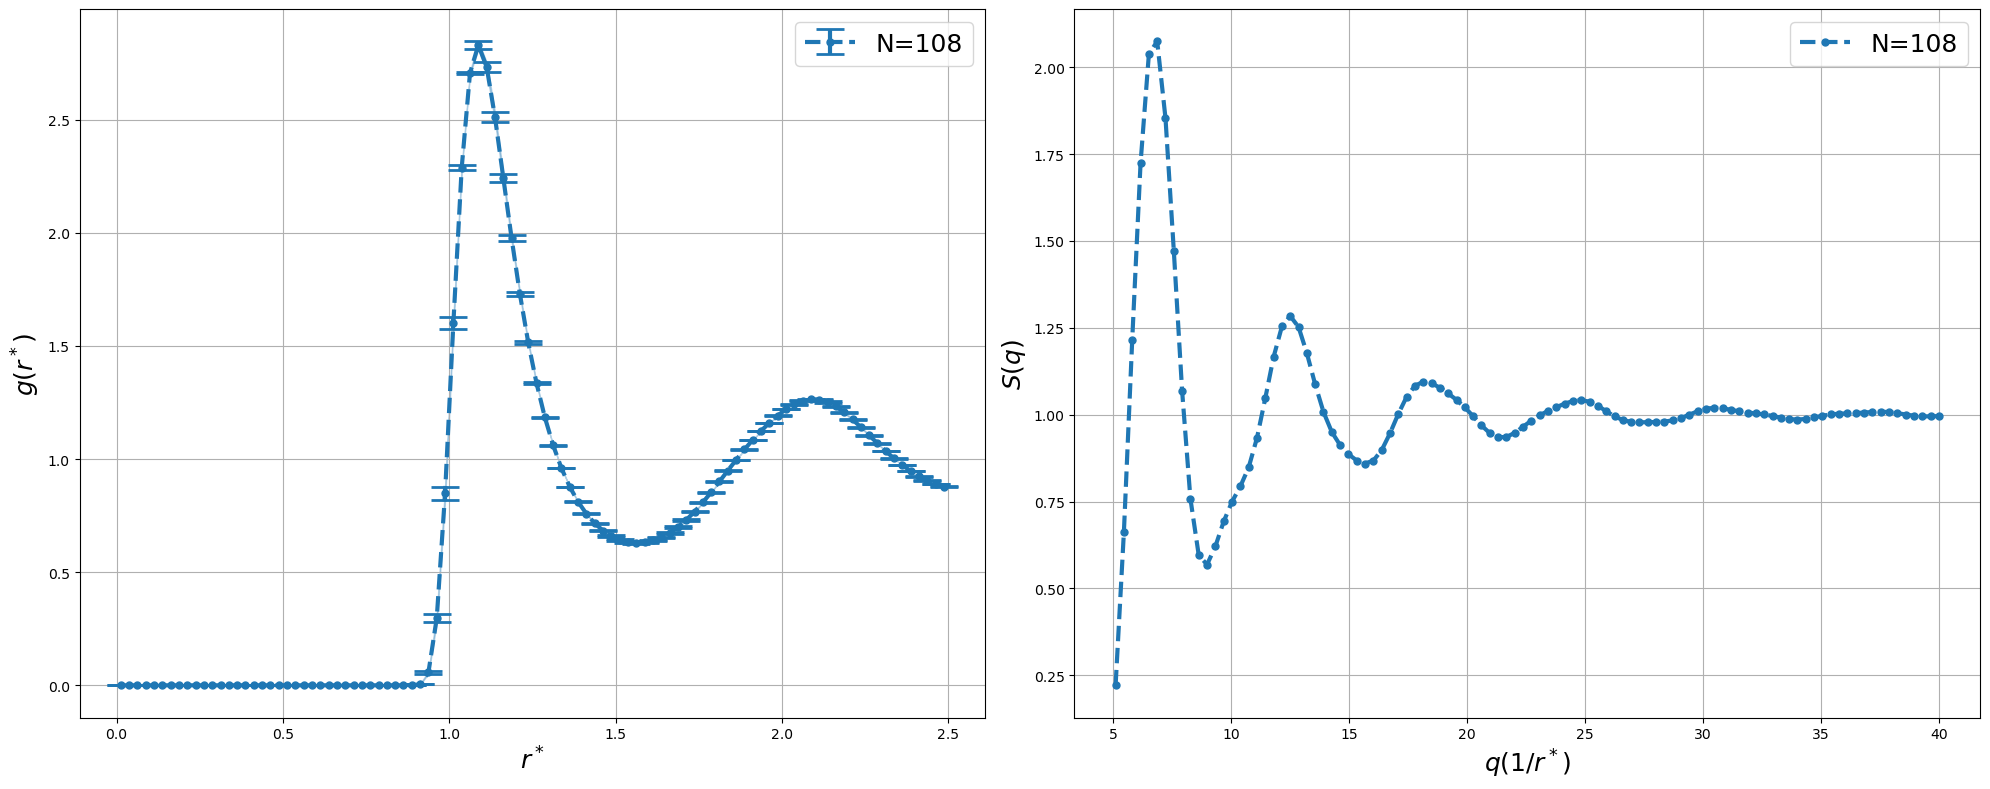

In [10]:
# Function to read and average RDF data
def read_and_average_rdf(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    data_blocks = []
    i = 0
    while i < len(lines):
        if lines[i].startswith('#') or lines[i].strip() == '':
            i += 1
            continue

        if len(lines[i].split()) == 2:  # Header line with timestep and number of rows
            timestep, num_rows = map(int, lines[i].split())
            i += 1

            block_data = []
            for _ in range(num_rows):
                parts = lines[i].strip().split()
                block_data.append([float(x) for x in parts])
                i += 1

            # print(block_data)

            data_blocks.append(np.array(block_data))
        else:
            i += 1

    # Combine and average data over all timesteps
    combined_data = np.stack(data_blocks)
    avg_r = data_blocks[0][:, 1]  # r values are the same for all blocks
    avg_gr = np.mean([block[:, 2] for block in data_blocks], axis=0)

    return avg_r, avg_gr

def compute_structure_factor(r, g_r, rho, q_max, num_q_points):
    dr = r[1] - r[0]
    q_values = np.linspace(0.1,  q_max, num=500)
    S_q = []

    for q in q_values:
        integrand = r * (g_r - 1) * np.sin(q * r)
        integral = np.trapz(integrand, r)
        S = 1 + 4 * np.pi * rho * integral / q
        S_q.append(S)

    return q_values, np.array(S_q)


r_list,gr_avg_list = [], []


seeds = (15061999, 31081973, 25021972, 10052004, 30071950)

for seed in seeds:
    rdf_filename = f'rdf_output_{seed}.txt'
    r_list.append(read_and_average_rdf(rdf_filename)[0])
    gr_avg_list.append(read_and_average_rdf(rdf_filename)[1])


r = np.mean(r_list, axis=0)
gr_avg = np.mean(gr_avg_list, axis=0)
gr_avg_error = sem(gr_avg_list, axis=0)


FONTSIZE=18
fig, ax = plt.subplots(1,2, figsize=(20,8))

ax[0].errorbar(r, gr_avg, yerr=gr_avg_error,label='N=108', capsize=10, capthick=2, markersize=5, marker='o', ls='--', lw=3)

ax[0].fill_between(r, gr_avg - gr_avg_error, gr_avg + gr_avg_error, color='tab:blue', alpha=0.3)


ax[0].set_xlabel(r'$r^*$', fontsize=FONTSIZE)
ax[0].set_ylabel(r'$g(r^*)$', fontsize=FONTSIZE)
ax[0].legend(fontsize=FONTSIZE)
ax[0].grid()






# Define particle density (use your simulation value here)
rho = 0.80726

# Set range of q values
q_min = 5.1
q_max = 40.0
num_q = len(r)
q_values = np.linspace(q_min, q_max, num_q)

r = np.mean(r_list, axis=0)
gr_avg = np.mean(gr_avg_list, axis=0)
gr_avg_error = sem(gr_avg_list, axis=0)

S_q = []
for q in q_values:
    integrand = (gr_avg - 1.0) * r * np.sin(q * r)
    integral = np.trapz(integrand, r)
    S_q.append(1 + (4 * np.pi * rho / q) * integral)

ax[1].errorbar(q_values, S_q,label='N=108', capsize=10, capthick=2, markersize=5, marker='o', ls='--', lw=3)
ax[1].set_xlabel(r"$q (1 / r^*)$", fontsize=FONTSIZE)
ax[1].set_ylabel(r"$S(q)$", fontsize=FONTSIZE)
ax[1].legend(fontsize=FONTSIZE)
ax[1].grid()

plt.tight_layout()

plt.savefig('gr.png', dpi=300)
plt.show()



/var/folders/87/z37n4g2j595fd7ly45xb9y680000gn/T/ipykernel_12419/3214666327.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  power_spectrum[i] = np.trapz(integrand, u)
/var/folders/87/z37n4g2j595fd7ly45xb9y680000gn/T/ipykernel_12419/3214666327.py:41: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integrals_list.append(np.trapz( vacf_local[:,3], vacf_local[:,1]*0.01)/2.)


0.027454500734484143 0.00018328051509304086


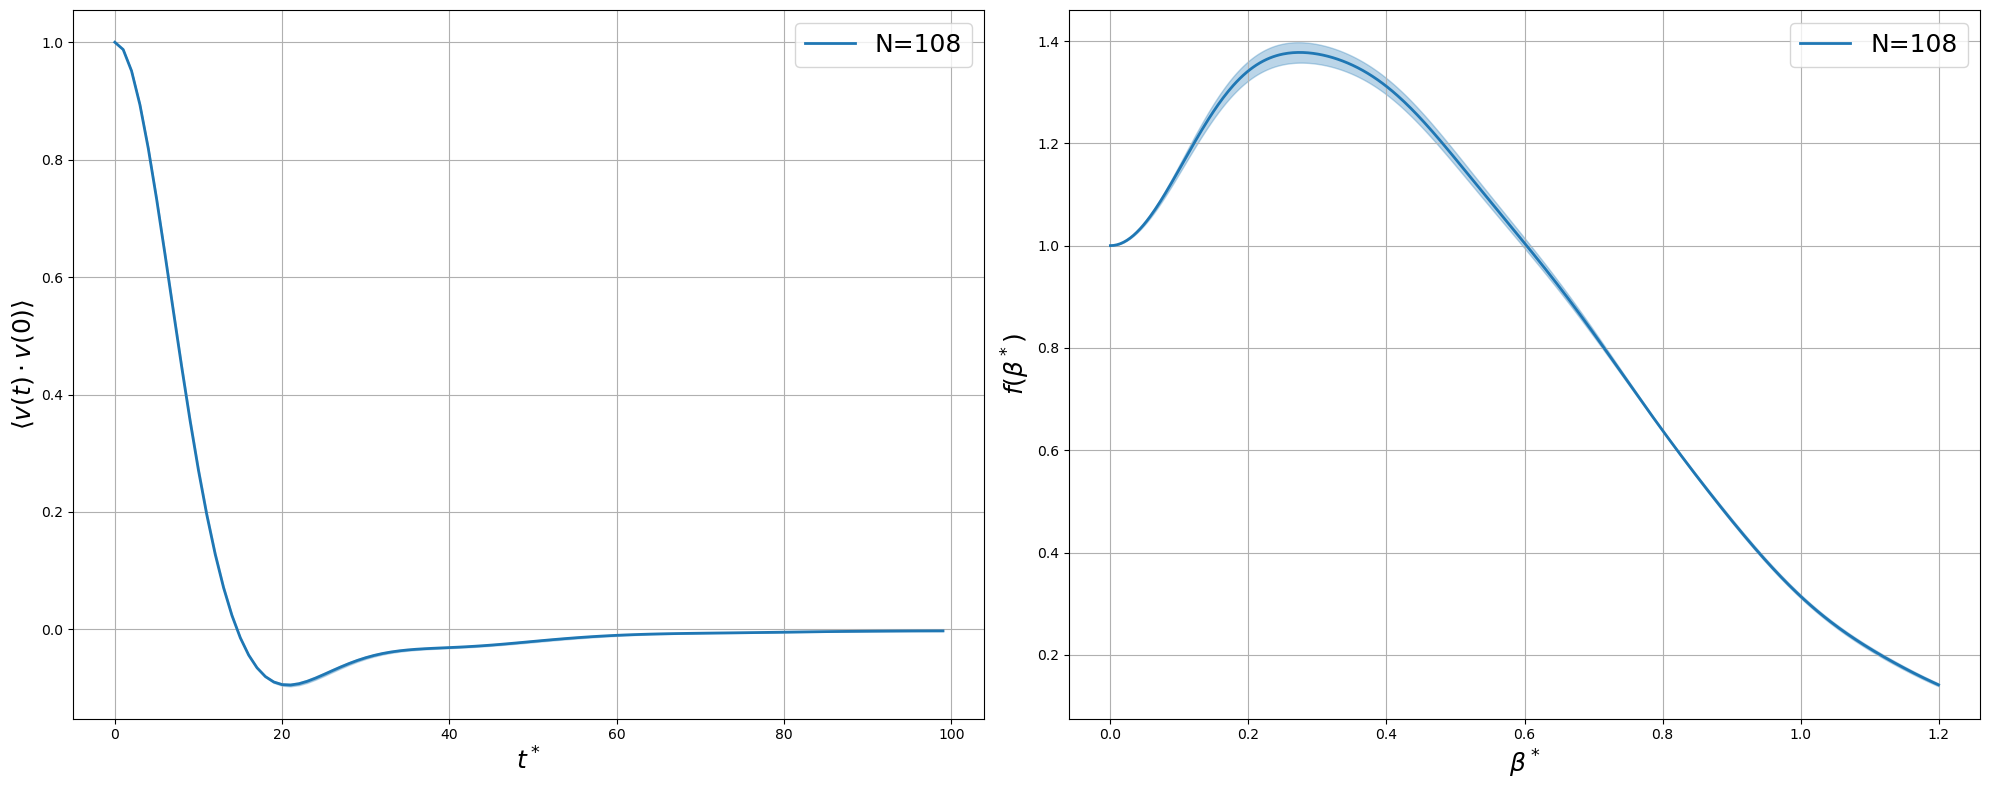

In [15]:
vacf_list = []
ps_list = []

integrals_list = []

fig, ax = plt.subplots(1,2, figsize=(20,8))

hbar = 0.0295  
kB = 1.    
T = 0.7833 
M = 1.0     
D = 3  

seeds = (15061999, 31081973, 25021972, 10052004, 30071950)
# seeds = (15061999)

for seed in seeds:
    vacf_local = np.loadtxt(f'vacf_output_{seed}.txt', skiprows=4)
    vacf_list.append(vacf_local[:,3] / np.max(vacf_local[:,3]))
    # vacf_list.append(vacf_local[:,3])


    vacf_local[:,3] /= vacf_local[:,3][0]
    u = vacf_local[:,1]*0.01 * kB * T / hbar

    beta_max = 1.2
    n_beta = 500
    beta_values = np.linspace(0, beta_max, n_beta)
    power_spectrum = np.zeros_like(beta_values)

    for i, beta in enumerate(beta_values):
        integrand = vacf_local[:,3] * np.cos(beta*u)
        power_spectrum[i] = np.trapz(integrand, u)

    lam = hbar / (M * D)
    power_spectrum *= lam

    power_spectrum /= power_spectrum[0]
    ps_list.append(power_spectrum)

    integrals_list.append(np.trapz( vacf_local[:,3], vacf_local[:,1]*0.01)/2.)
    
time = vacf_local[:,1]
vacf = np.average(vacf_list, axis=0)
vacf_error = sem(vacf_list, axis=0)

ps = np.average(ps_list, axis=0)
ps_error = sem(ps_list, axis=0)

ax[0].fill_between(time, vacf - vacf_error, vacf + vacf_error, color='tab:blue', alpha=0.3)
ax[0].errorbar(time, vacf, label='N=108', capsize=1, capthick=0.5, markersize=0.2, marker='', ls='solid', lw=2)
ax[0].legend()
ax[0].grid()

ax[1].fill_between(beta_values, ps - ps_error, ps + ps_error, color='tab:blue', alpha=0.3)
ax[1].errorbar(beta_values, ps, label='N=108', capsize=1, capthick=0.5, markersize=0.2, marker='', ls='solid', lw=2)
ax[1].legend()
ax[1].grid()

print(np.average(integrals_list), sem(integrals_list))
ax[1].set_xlabel(r"$\beta^*$", fontsize=FONTSIZE)
ax[1].set_ylabel(r"$f(\beta^*)$", fontsize=FONTSIZE)

ax[0].set_xlabel(r"$t^*$", fontsize=FONTSIZE)
ax[0].set_ylabel(r"$\langle v(t) \cdot v(0) \rangle$", fontsize=FONTSIZE)
ax[0].legend(fontsize=FONTSIZE)
ax[1].legend(fontsize=FONTSIZE)
plt.tight_layout()

plt.savefig('vacf.png', dpi=300)



0.04166216709054683 0.001671750922517653


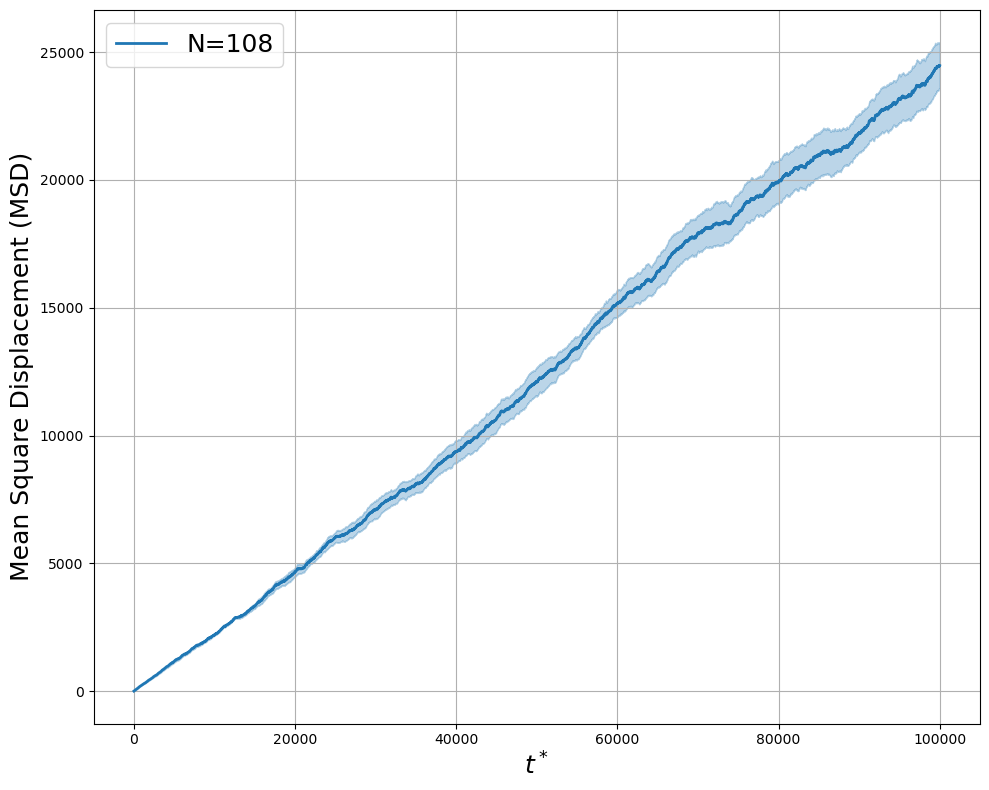

In [14]:
msd_list = []
dcoef_list = []


fig, ax = plt.subplots(1,1, figsize=(10,8))


seeds = (15061999, 31081973, 25021972, 10052004, 30071950)

for seed in seeds:
    msd_local = np.loadtxt(f'msd_output_{seed}.txt', skiprows=2)
    msd_list.append(msd_local[:,1])

    time = msd_local[:,0]*0.01
    slope_local  = linregress(time, msd_local[:,1])[0]
    dcoef_list.append(slope_local/6)

    
time = msd_local[:,0]*0.01
msd = np.average(msd_list, axis=0)
msd_error = sem(msd_list, axis=0)
ax.fill_between(time, msd - msd_error, msd + msd_error, color='tab:blue', alpha=0.3)
ax.errorbar(time, msd, label='N=108', capsize=1, capthick=0.5, markersize=0.2, marker='', ls='solid', lw=2)

ax.set_xlabel(r"$t^*$", fontsize=FONTSIZE)
ax.set_ylabel(r"Mean Square Displacement (MSD)", fontsize=FONTSIZE)
ax.legend(fontsize=FONTSIZE)
ax.grid()

print(np.average(dcoef_list), sem(dcoef_list))
plt.tight_layout()

plt.savefig('msd.png', dpi=300)


In [21]:
def calc_cv(seeds, N, T):
    cvs = []
    for seed in seeds:
        ene = np.loadtxt(f'energy_output_{seed}.txt', skiprows=2)[:,1]
        # print(ene)
        ene_average = np.average(ene)
        delta_k_squared = np.average(np.square(ene - ene_average))
        print(delta_k_squared)
        # print(ene_average)

        j = 1 - delta_k_squared*2./3. * 1/(T**2 * N)

        cvs.append(3.*N/2. * 1./j)

    return np.average(cvs)/float(N), sem(cvs)

seeds = (15061999, 31081973, 25021972, 10052004, 30071950)
T = 0.7833 

print(calc_cv(seeds, 108, T))

0.0039924664118577416
0.0038815640308261885
0.0031503161703458227
0.003004535260659083
0.0034413847077777193
(np.float64(1.500052730874745), np.float64(0.00031755546177425774))
